In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', None)

In [3]:
df_data = pd.read_csv("../data/data_processed.csv")

In [4]:
df_data.head(5)

,Prescribed_for,DrugName_list,Disease,Symptoms,Symptoms_Length,Number_of_Drugs
0,ADHD,['Clonidine' 'Bupropion' 'Vyvanse' 'Dexmethylphenidate'\n 'Amphetamine / dextroamphetamine' 'Adderall' 'Aptensio XR' 'Atomoxetine'\n 'Lisdexamfetamine' 'Focalin XR' 'Concerta' 'Guanfacine' 'Ritalin'\n 'Amphetamine' 'Methylphenidate' 'Dextroamphetamine' 'Strattera'\n 'Adzenys XR-ODT' 'Adderall XR' 'Daytrana' 'Methylin' 'Focalin'\n 'Omega-3 polyunsaturated fatty acids' 'Dexedrine' 'Metadate ER'\n 'Metadate CD' 'Wellbutrin XL' 'Intuniv' 'Armodafinil' 'Evekeo' 'Kapvay'\n 'Pristiq' 'Dyanavel XR' 'Quillivant XR' 'Methamphetamine' 'Desoxyn'\n 'Desvenlafaxine' 'Ritalin LA' 'Dextrostat' 'Cylert' 'Modafinil'\n 'Provigil' 'Mydayis' 'Nuvigil' 'Methylin ER' 'Pemoline'],Attention deficit hyperactivity disorder,Inattention carelessness hyperactivity executive dysfunction disinhibition emotional dysregulation impulsivity impaired working memory,134,46
1,AIDS Related Wasting,['Serostim'],HIV/AIDS,"Early : Flu-like illness Later : Large lymph nodes , fever, weight loss",71,1
2,Abnormal Uterine Bleeding,['Ethinyl estradiol / levonorgestrel' 'Mirena' 'Levonorgestrel'\n 'Medroxyprogesterone' 'Depo-Provera' 'Tri-Sprintec' 'Levlen' 'Alesse'\n 'Junel Fe 1 / 20' 'Ortho Tri-Cyclen Lo' 'Aviane'\n 'Ethinyl estradiol / norethindrone' 'Sprintec' 'Necon 1 / 50'\n 'Ethinyl estradiol / norgestimate' 'Norethindrone' 'Loestrin 24 Fe'\n 'Megestrol' 'Estarylla' 'Chateal' 'Falmina' 'Seasonique'\n 'Desogestrel / ethinyl estradiol' 'Ortho Tri-Cyclen'\n 'Ethinyl estradiol / norgestrel' 'Nora-Be' 'Ortho Cyclen' 'Provera'\n 'Levora' 'Jolessa' 'Ortho Micronor' 'TriNessa' 'LoSeasonique' 'Seasonale'\n 'Mononessa' 'Ovcon 35' 'Conjugated estrogens' 'Previfem'],Abnormal uterine bleeding,"Irregular, abnormally frequent, prolonged, or excessive amounts of uterine bleeding",83,38
3,Abortion,['Misoprostol'],NaN,NaN,3,1
4,Acetaminophen Overdose,['Mucomyst-10'],Paracetamol poisoning,"Early : Non specific, feeling tired, abdominal pain , nausea Later : Yellowish skin , blood clotting problems , confusion",121,1


### Groupby analysis on disease

In [5]:
# Group by 'Disease' and aggregate 'Prescribed_for' values into unique sets
aggregated_data = df_data.groupby('Disease')['Prescribed_for'].agg(lambda x: set(x.unique()))

# Convert the aggregated data into a DataFrame for easier manipulation
aggregated_df = aggregated_data.reset_index(name='Unique_Prescribed_for')

# Sort the DataFrame directly by the length of the 'Unique_Prescribed_for' sets in descending order
sorted_aggregated_df = aggregated_df.iloc[aggregated_df['Unique_Prescribed_for'].apply(len).argsort()[::-1]]


### under each diseases different categories of prescribed for

In [6]:
sorted_aggregated_df.head(10)

,Disease,Unique_Prescribed_for
75,Conjunctivitis,"{Conjunctivitis, Allergic, Seasonal Allergic Conjunctivitis, Eye Redness/Itching, Bacterial Infection, Conjunctivitis, Conjunctivitis, Bacterial}"
98,Dyslipidemia,"{Hypertriglyceridemia, Hyperlipoproteinemia Type IIa, Elevated LDL, High Cholesterol, Familial Homozygous, High Cholesterol, Familial Heterozygous, Hyperlipoproteinemia}"
321,Ulcerative colitis,"{Steroid Responsive Inflammatory Conditions, Ulcerative Colitis, Active, Ulcerative Proctitis, Ulcerative Colitis, Maintenance, Ulcerative Colitis}"
84,Deep vein thrombosis,"{Deep Vein Thrombosis, Prophylaxis, Deep Vein Thrombosis, Recurrent Event, Deep Vein Thrombosis, Deep Vein Thrombosis, First Event, Deep Vein Thrombosis Prophylaxis after Hip Replacement Surgery}"
129,Glaucoma,"{Postoperative Increased Intraocular Pressure, Postoperative Ocular Inflammation, Intraocular Hypertension, Glaucoma, Open Angle, Glaucoma}"
240,Pain,"{Breakthrough Pain, Back Pain, Postoperative Pain, Labor Pain, Pain}"
76,Constipation,"{Constipation, Chronic, Constipation, Opioid-Induced Constipation, Constipation, Drug Induced, Constipation, Acute}"
118,Gastroenteritis,"{Diarrhea, Acute, Gastric Ulcer Maintenance Treatment, Salmonella Gastroenteritis, Gastroenteritis, Noninfectious Colitis}"
64,Chronic obstructive pulmonary disease,"{COPD, COPD, Maintenance, COPD, Acute, Smoking Cessation}"
319,Type 1 diabetes,"{Diabetes, Type 1, Thyroid Cance, Organ Transplant, Rejection Reversal, Pancreatic Cance}"


### Co-ocurences of diseases - Which Diseases come together

In [12]:
from itertools import combinations
from collections import Counter


# Tokenizing the diseases
diseases_tokenized = df_data['Prescribed_for'].str.split(', ')

# co-occurrences of diseases- counting
disease_pairs = Counter()
for diseases in diseases_tokenized:
    disease_pairs.update(combinations(diseases, 2))

# Most common diseases occuring together
print("Understanding prescribed_for column : \n")
for pair, count in disease_pairs.most_common(20):
    print(pair, "-", count)


Understanding prescribed_for column : 

('Anemia', 'Chemotherapy Induced') - 1
('Anemia', 'Sickle Cell') - 1
('Aspergillosis', 'Aspergilloma') - 1
('Asthma', 'Maintenance') - 1
('Asthma', 'acute') - 1
('Breast Cancer', 'Adjuvant') - 1
('Breast Cancer', 'Metastatic') - 1
('Breast Cancer', 'Palliative') - 1
('Breast Cancer', 'Prevention') - 1
('Burns', 'External') - 1
('COPD', 'Acute') - 1
('COPD', 'Maintenance') - 1
('Conjunctivitis', 'Allergic') - 1
('Conjunctivitis', 'Bacterial') - 1
('Constipation', 'Acute') - 1
('Constipation', 'Chronic') - 1
('Constipation', 'Drug Induced') - 1
("Crohn's Disease", 'Acute') - 1
("Crohn's Disease", 'Maintenance') - 1
('Deep Vein Thrombosis', 'First Event') - 1


### Co-ocurences of Symptoms - Which Symptoms come together

In [13]:
# Tokenizing the symptoms
symptoms_tokenized = df_data['Symptoms'].dropna().str.split(', ')

# Countig the co-occurrences of symptoms
symptom_pairs = Counter()
for symptoms in symptoms_tokenized:
  symptom_pairs.update(combinations(symptoms,3))


# Most common symptoms occuring together
print("Symptoms that are occuring together are : \n")
symptom_cooccuring={}
for pair, count in symptom_pairs.most_common(30):
  symptom_cooccuring[pair]=count
  print(pair, "-", count)


Symptoms that are occuring together are : 

('Abdominal pain ', 'fever ', 'fatigue ') - 9
('Abdominal pain ', 'weight loss ', 'fatigue ') - 9
('Infrequent or hard to pass bowel movements ', 'abdominal pain', 'bloating') - 5
('Pain', 'swelling ', 'redness') - 5
('Pain', 'swelling ', 'enlarged veins in the affected limb') - 5
('Pain', 'redness', 'enlarged veins in the affected limb') - 5
('swelling ', 'redness', 'enlarged veins in the affected limb') - 5
('Diarrhea ', 'vomiting ', 'abdominal pain') - 5
('Diarrhea ', 'vomiting ', 'fever') - 5
('Diarrhea ', 'abdominal pain', 'fever') - 5
('vomiting ', 'abdominal pain', 'fever') - 5
('Abdominal pain ', 'diarrhea mixed with blood ', 'weight loss ') - 5
('Abdominal pain ', 'diarrhea mixed with blood ', 'fever ') - 5
('Abdominal pain ', 'diarrhea mixed with blood ', 'anemia ') - 5
('Abdominal pain ', 'diarrhea mixed with blood ', 'dehydration ') - 5
('Abdominal pain ', 'diarrhea mixed with blood ', 'loss of appetite') - 5
('Abdominal pain ', '

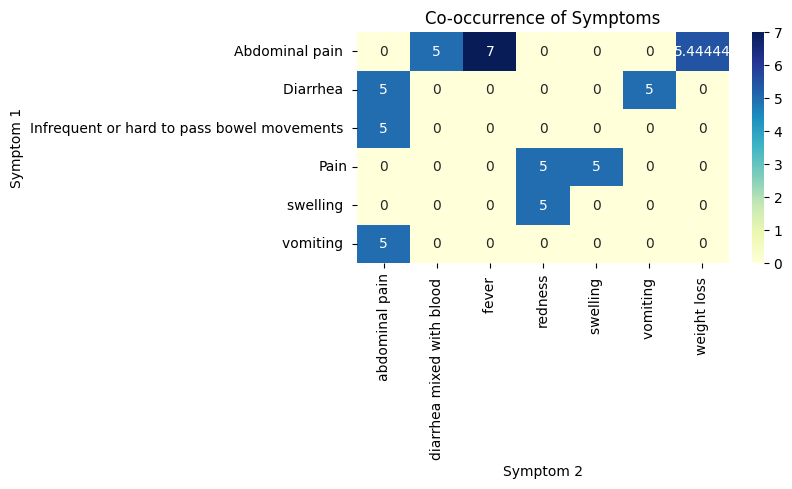

In [14]:
df = pd.DataFrame(symptom_cooccuring.items(), columns=['Symptom Pair', 'Count'])
df = df.groupby('Symptom Pair')['Count'].sum().reset_index()
df[['Symptom 1', 'Symptom 2', 'Symptom 3']] = pd.DataFrame(df['Symptom Pair'].tolist(), index=df.index)
pivot_table = df.pivot_table(index='Symptom 1', columns='Symptom 2', values='Count', fill_value=0)

# Plotting the heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt='g')
plt.title('Co-occurrence of Symptoms')
plt.xlabel('Symptom 2')
plt.ylabel('Symptom 1')
plt.show()


### No of Drugs for each disease:

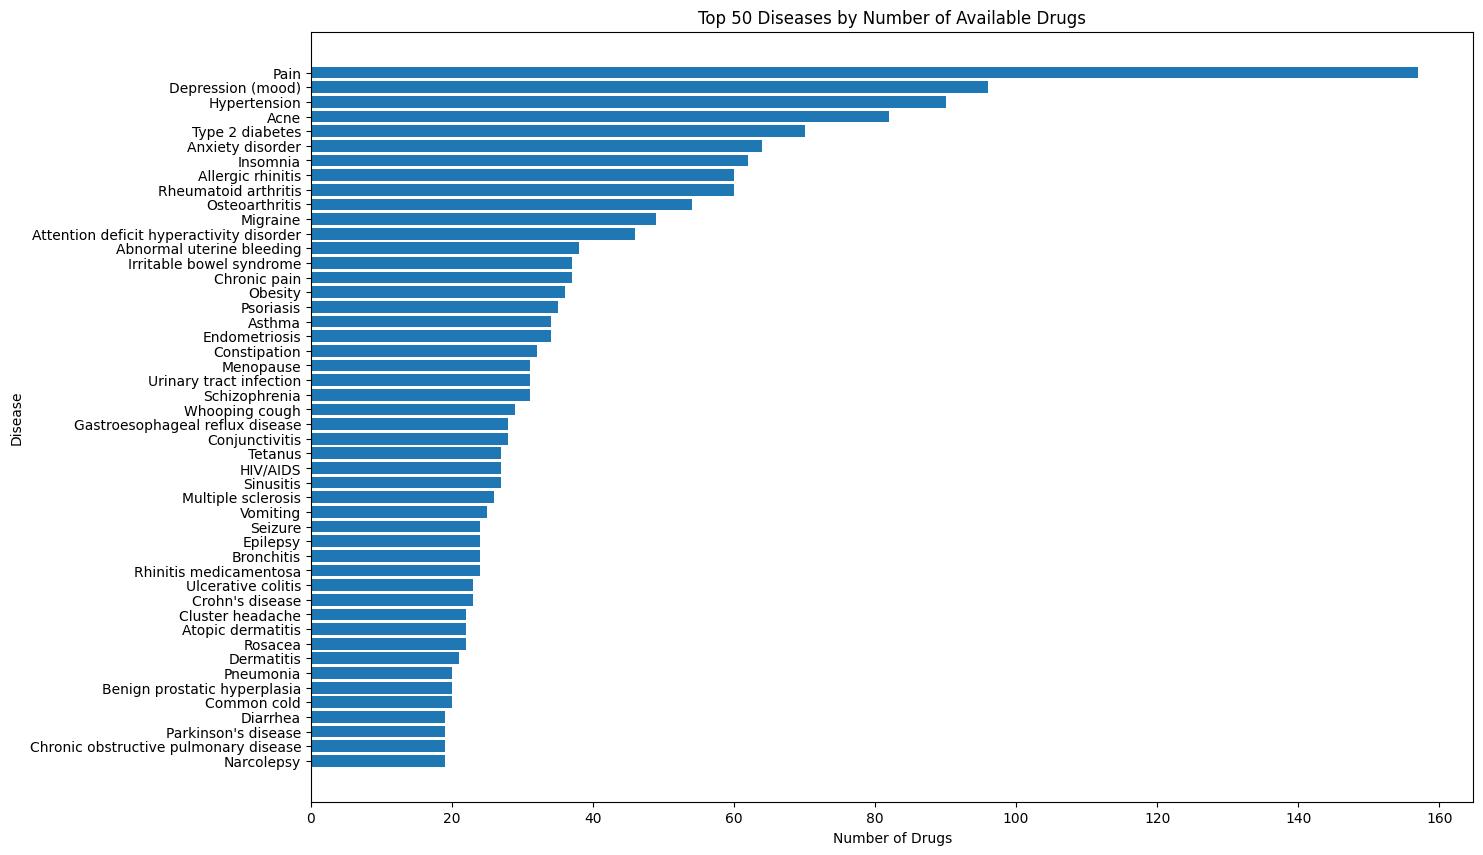

In [21]:
df_sorted = df_data.dropna().sort_values(by='Number_of_Drugs', ascending=False)
top_50 = df_sorted.head(50)

# Plotting
plt.figure(figsize=(15, 10))  
plt.barh(top_50['Disease'], top_50['Number_of_Drugs'])
plt.xlabel('Number of Drugs')  
plt.ylabel('Disease') 
plt.title('Top 50 Diseases by Number of Available Drugs')  
plt.gca().invert_yaxis()  # Invert y-axis to have the disease with the highest count on top
plt.show()

### Word Cloud Plot

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

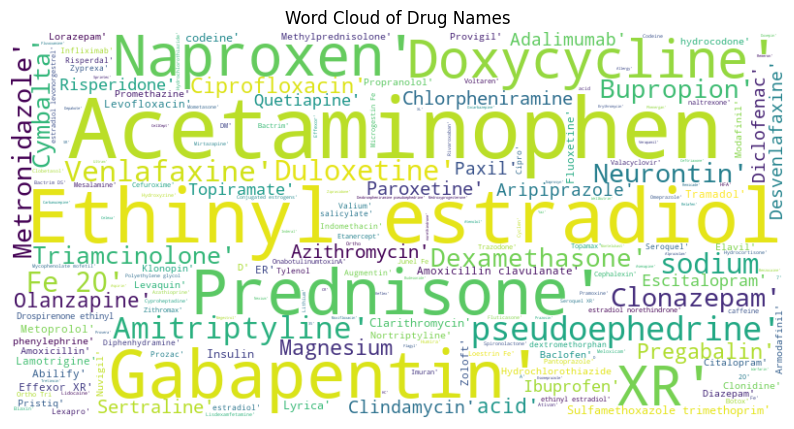

In [26]:
# Joining all drug names into a single string
all_drugs = ' '.join(df_data['DrugName_list'].explode().dropna())

# Generating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_drugs)

# word cloud plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Drug Names')
plt.axis('off')
plt.show()

In [27]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string

In [28]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shobanasiranjeevilu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shobanasiranjeevilu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
# Preprocessing function
def preprocess_text(text):
    if pd.isnull(text):
        return None
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Stem the words
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Preprocessing the symptoms
df_data['Preprocessed_Symptoms'] = df_data['Symptoms'].apply(preprocess_text)


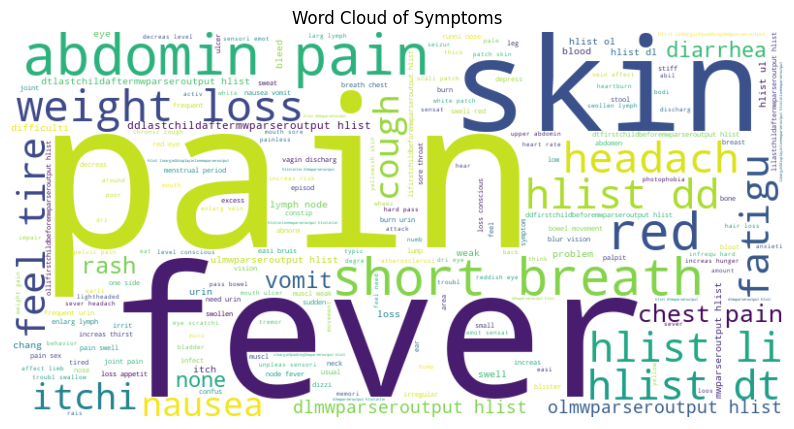

In [32]:
# Word cloud generation
all_preprocessed_symptoms = ' '.join(df_data['Preprocessed_Symptoms'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_preprocessed_symptoms)

# Word cloud Plot
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Symptoms')
plt.axis('off')
plt.show()
